# Inicialización y preprocesamiento de datos

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from IPython.display import  HTML 
import math

sb.set()

In [10]:
all_data = np.load('dataset/proyecto_training_data.npy')
n_training_rows   = int(len(all_data) * 0.8)
training_data = all_data[:n_training_rows]
testing_data  = all_data[n_training_rows:]

print("training rows:  ", len(training_data))
print("testing  rows:  ", len(testing_data))
print("total data rows:", len(all_data))

training rows:   1168
testing  rows:   292
total data rows: 1460


In [11]:
# preprocessing
training_data[:,0] /= 1000 # expresar precio de venta en miles de dólares
training_data[:,2] /= 1000 # expresar pies cuadrados en el primer nivel en miles de pies^2


variables   = {}
for column, name in enumerate(('sale_price', 'quality', 'fst_fl_sqf', 'total_rooms', 'year_built', 'lot_front')):
    variables[name] = training_data[:,column]
    globals()[name] = training_data[:,column]
    

# Análisis exploratorio de datos

### Resumen de variables

In [12]:
rows = []
for name, values in variables.items():
    mean  = np.nanmean(values)
    max_v = np.nanmax(values)
    min_v = np.nanmin(values)
    rng   = max_v - min_v
    std   = np.nanstd(values)
    rows.append({'avg': mean, 'min': min_v, 'max': max_v, 'range': rng, 'std': std})
    
df = pd.DataFrame(rows, index=variables.keys()).round(2)
HTML(df.to_html())

,avg,min,max,range,std
sale_price,180.59,34.90,755.00,720.10,78.78
quality,6.10,1.00,10.00,9.00,1.38
fst_fl_sqf,1.16,0.33,3.23,2.89,0.37
total_rooms,6.49,2.00,14.00,12.00,1.61
year_built,1971.45,1875.00,2010.00,135.00,29.94
lot_front,69.95,21.00,313.00,292.00,23.47


### Histogramas

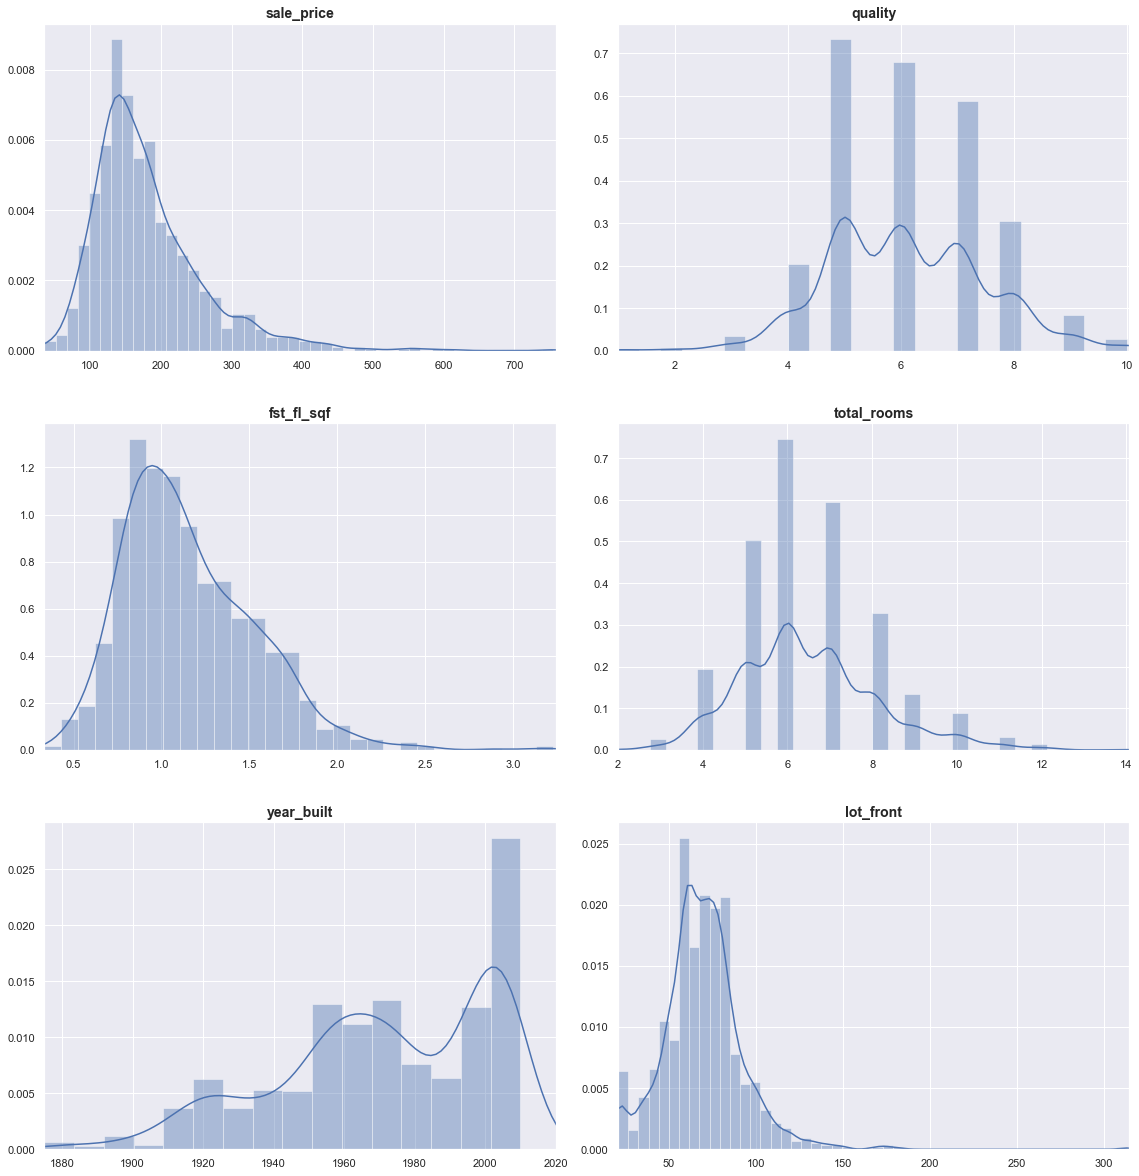

In [116]:
n = len(variables)
cols = 2
rows = n // cols

fig,ax = plt.subplots(rows, cols, figsize=(16,n*2.75))

i = 0
for name, values in variables.items():
    current_ax = ax[i//cols][i%cols]
    current_ax.set_title(name,  weight='bold').set_fontsize(14)
    current_ax.set_xlim(np.nanmin(values), np.nanmax(values) * 1.005)
    sb.distplot(values[~np.isnan(values)],  ax=current_ax)
    i+=1

fig.tight_layout(h_pad=3)

### Correlación entre variables

In [14]:
independent_vars = [(name,values) for name,values in variables.items()][1:]

for name, values in independent_vars:
    not_nan = ~np.isnan(values)
    values = values[not_nan]
    print(name, np.corrcoef(values, sale_price[not_nan])[1][0]) #TODO make dataframe

quality 0.7939900504626412
fst_fl_sqf 0.6162887000998714
total_rooms 0.5647069399593065
year_built 0.5341706927117518
lot_front 0.36329161665389204


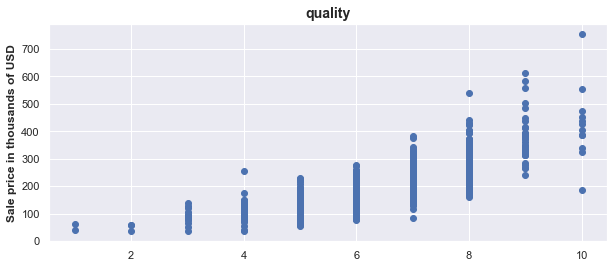

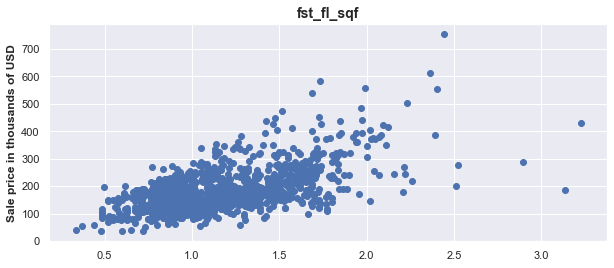

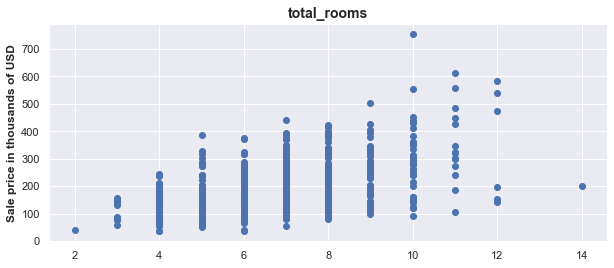

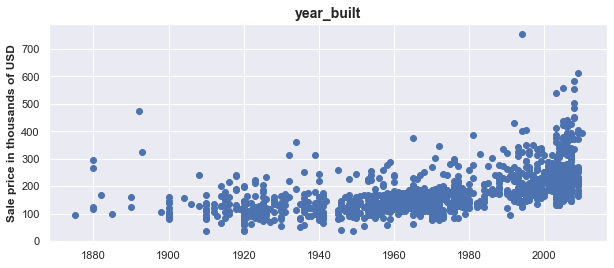

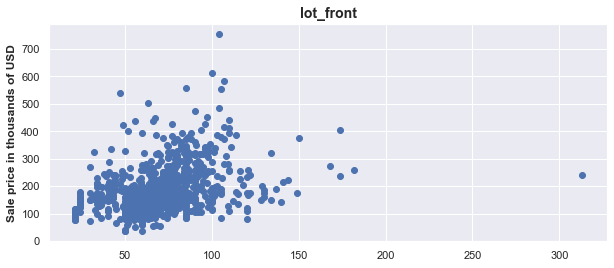

In [15]:
for name, values in independent_vars:
    plt.figure(figsize=(10,4))
    plt.scatter(x = values, y = sale_price)
    plt.ylabel("Sale price in thousands of USD", weight='bold')
    plt.gca().set_title(name,  weight='bold').set_fontsize(14) #TODO include r from dataframe above

## Selección de variables
De las gráficas y coeficientes de correlación de arriba, notamos que quality (r=0.79399) y fst_fl_sqf (r=0.61628) son las dos variables independientes que muestran mayor correlación con el precio de venta. Estas dos serán las variables para las que desarrollaremos modelos de regresión.

# Entrenamiento manual del modelo
#### Función de entrenamiento

In [234]:
def train(x, y, epochs, error_report_rate, learning_rate):
    linear_regression_params = np.array([0.0, 0.0])
    error_history = np.zeros([epochs])
    param_history = np.zeros([epochs, 2])
    
    x = np.vstack((x, np.ones_like(x)))

    for epoch in range(0, epochs):
        y_hat = np.matmul(linear_regression_params, x)

        gradients = np.average((y_hat - y) * x, axis=1)
        
        linear_regression_params -= (learning_rate * gradients)
        
        error_history[epoch] = 0.5 * np.average(np.power(y - y_hat, 2))
        param_history[epoch] = linear_regression_params.copy()
        
        if epoch % error_report_rate == 0 or epoch == epochs - 1:
            print("epoch:", epoch, "error:", error_history[epoch])
    
    return (param_history, error_history)

#### Funciones de visualización


In [228]:
def plot_error(error_data, ax=None):
    if ax is None:
        ax = plt.gca()
    x = range(0, len(error_data))
    return ax.plot(x, error_data)

def plot_model_progress(model_data, x, y, n, x_label='', epoch_offset=0):
    num_plots = len(model_data) // n
    cols = 2
    rows = math.ceil(num_plots / cols)
    
    fig,ax = plt.subplots(rows, cols, figsize=(16,num_plots*2.75))

    for i in range(0, num_plots):
        epoch = n * i
        current_ax = ax[i // cols][i % cols]
        current_model = model_data[epoch]
        
        # scatter
        current_ax.scatter(x = x, y = y)
        
        # model line
        m,b = current_model[0], current_model[1]
        y_hat = m * x + b
        current_ax.plot(x, y_hat, 'k--')
        
        # text
        title = 'epoch ' + str(epoch + epoch_offset) + ': m=' + str(round(m, 2)) + ',  b=' + str(round(b,2))
        current_ax.set_title(title, weight='demi').set_fontsize(14)
        if i == 0:
            current_ax.set_ylabel("Sale price in thousands of USD", weight='semibold')
            current_ax.set_xlabel(x_label, weight='semibold')
        
    
    fig.subplots_adjust(hspace=0.4)
    
    if num_plots % cols != 0:
        ax[-1][-1].axis('off')


## Ajuste de parámetros del modelo: epochs y learning rate

In [268]:
def try_lr_values(lr_values, variable, epochs=1000, error_report_rate=300):
    cols = 2
    num_plots = len(lr_values)
    rows = math.ceil(num_plots / cols)
    
    fig,ax = plt.subplots(rows, cols, figsize=(16,rows*cols*2.25))

    for i,lr in enumerate(lr_values):
        print('experimentando con lr =', lr)
        print('====================================')
        model, errors = train(variable, sale_price, epochs, error_report_rate, lr)
        current_ax = ax[i // cols][i % cols]
        current_ax.set_title('lr='+str(lr), weight='bold').set_fontsize(14)
        plot_error(errors, current_ax)
        print('\n')

    if num_plots % cols != 0:
        ax[-1][-(num_plots % cols)].axis('off')


### Variable Independiente 1: overall quality

Utilizamos las funciones de visualización definidas arriba para estudiar el comportamiento del modelo según se cambien los parámetros de entrenamiento.

##### Experimentamos con diferentes valores de LR para encontrar uno adecuado

experimentando con lr = 0.001
epoch: 0 error: 19409.722053221747
epoch: 300 error: 1387.8258709101294
epoch: 600 error: 1381.0781494300654
epoch: 900 error: 1374.5194275821686
epoch: 999 error: 1372.395618718258


experimentando con lr = 0.03
epoch: 0 error: 19409.722053221747
epoch: 300 error: 1252.549425900785
epoch: 600 error: 1191.9365643097394
epoch: 900 error: 1166.1036655162636
epoch: 999 error: 1161.396865197008


experimentando con lr = 0.04
epoch: 0 error: 19409.722053221747
epoch: 300 error: 1226.3891982772927
epoch: 600 error: 1172.399003574547
epoch: 900 error: 1155.0872015451396
epoch: 999 error: 1152.5301016535216


experimentando con lr = 0.05
epoch: 0 error: 19409.722053221747
epoch: 300 error: 159229.21160025976
epoch: 600 error: 1387293.896063218
epoch: 900 error: 12159946.302279545
epoch: 999 error: 24895962.97754782




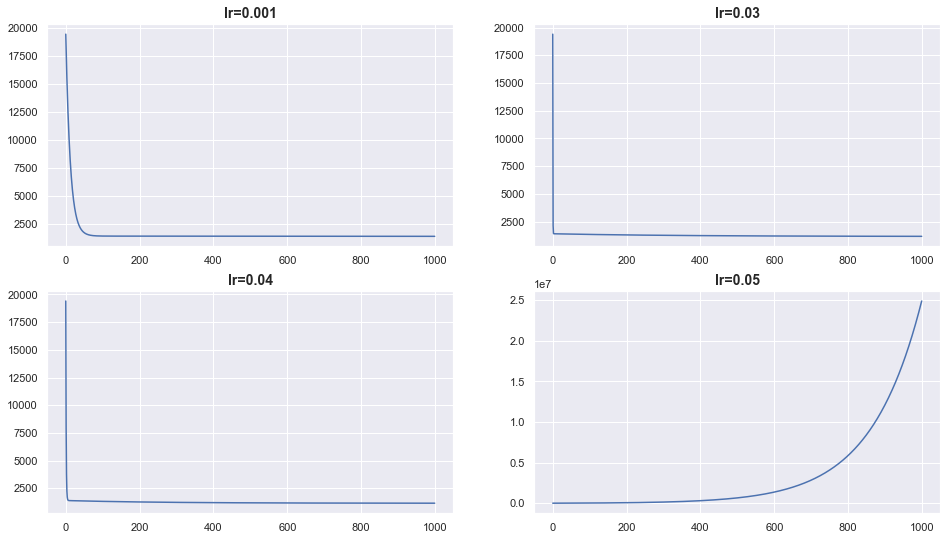

In [269]:
try_lr_values((0.001, 0.03, 0.04, 0.05), quality)

Podemos ver que un learning rate óptimo puede encontrarse entre 0.04 y 0.05, ya que a partir de ~0.5 el error empieza a diverger. Tras experimentar más con este valor y una cantidad de iteraciones grande (mayor a 10,000) se concluye que un buen valor de lr es 0.0495 y cualquier número entre 1000 y 2000 iteraciones es suficiente, pues el error se mantiene entre 1150 y 1146.91. Este último valor parece ser donde realmente se estabiliza el modelo, pues incluso tras 10,000 iteraciones el error se mantiene en este valor,

In [274]:
quality_model, quality_errors = train(quality, sale_price, 2000, 300, 0.0495)

epoch: 0 error: 19409.722053221747
epoch: 300 error: 1208.435749043506
epoch: 600 error: 1161.7528629544345
epoch: 900 error: 1150.5462105156712
epoch: 1200 error: 1147.8043497927008
epoch: 1500 error: 1147.1335135174352
epoch: 1800 error: 1146.9693836238976
epoch: 1999 error: 1146.9371142412933


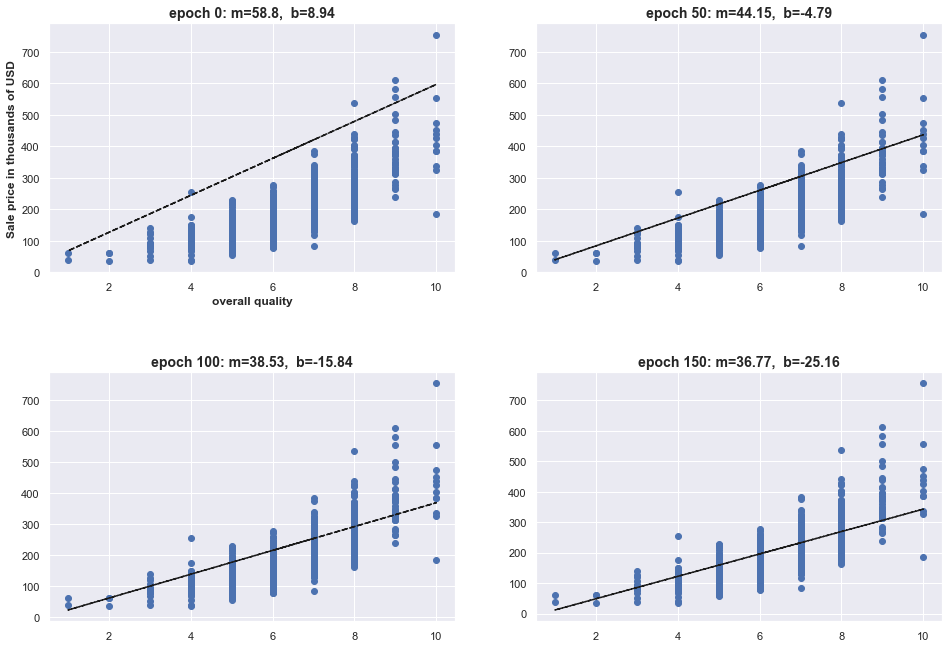

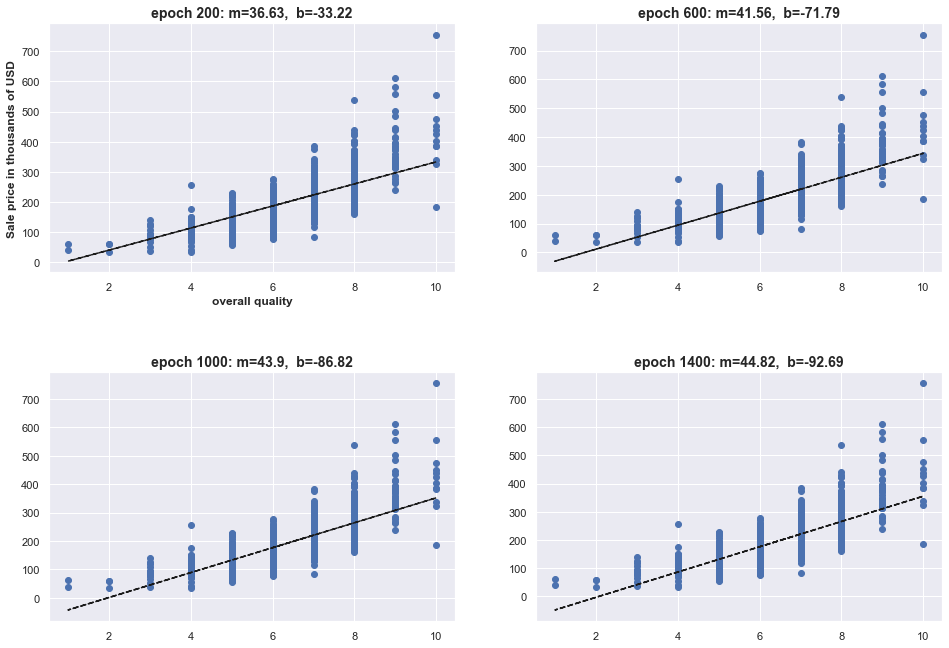

In [289]:
# el progreso es más notable en las primeras iteraciones
plot_model_progress(quality_model[:200], quality, sale_price, 50, 'overall quality')
plot_model_progress(quality_model[200:], quality, sale_price, 400, 'overall quality', epoch_offset=200)

### Variable Independiente 2: thousands of square feet in first floor

##### Experimentamos con diferentes valores de LR para encontrar uno adecuado

experimentando con lr = 0.001
epoch: 0 error: 19409.722053221747
epoch: 50 error: 15669.532674283018
epoch: 100 error: 12733.712335704118
epoch: 150 error: 10429.247621962966
epoch: 200 error: 8620.339077838018
epoch: 249 error: 7225.557438431763


experimentando con lr = 0.4
epoch: 0 error: 19409.722053221747
epoch: 50 error: 1934.212613706114
epoch: 100 error: 1925.5563451342675
epoch: 150 error: 1924.7186206538543
epoch: 200 error: 1924.63754850374
epoch: 249 error: 1924.6297428103032


experimentando con lr = 0.79
epoch: 0 error: 19409.722053221747
epoch: 50 error: 1927.1143148442295
epoch: 100 error: 1924.6377682703562
epoch: 150 error: 1924.6289444677236
epoch: 200 error: 1924.6288627362705
epoch: 249 error: 1924.6288619680695


experimentando con lr = 0.8
epoch: 0 error: 19409.722053221747
epoch: 50 error: 1946.8613285447905
epoch: 100 error: 1924.6628613751134
epoch: 150 error: 1924.6289629857647
epoch: 200 error: 1924.628862609045
epoch: 249 error: 1924.6288619660397


experim

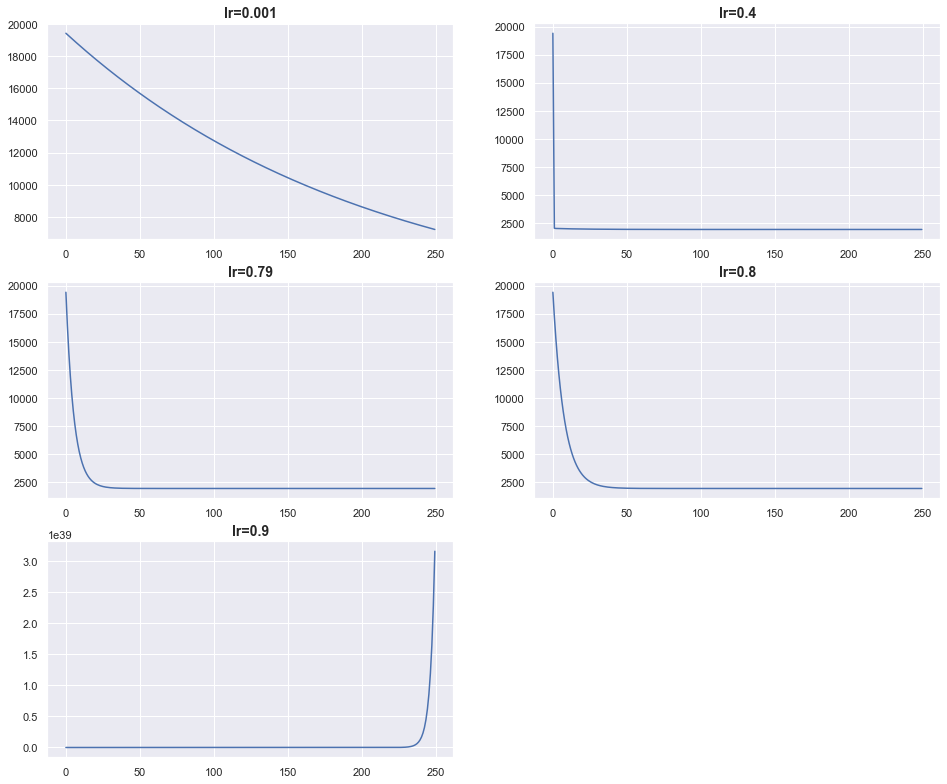

In [273]:
try_lr_values((0.001, 0.4, 0.79,0.8, 0.9), fst_fl_sqf, error_report_rate=50, epochs=250)

Se observa que para esta variable, el modelo converge bastante más rápido y es más permisivo con un rango mayor de valores para lr. Sin embargo, tras una experimentación similar a la hecha para la variable anterior, se elige como valor de lr 0.79, pues es la que más rápido parece converger, necesitando menos iteraciones. Aunque cabe mencionar que la diferencia con otros valores es marginal. Asimismo, 250 iteraciones son más que suficientes para este modelo.

In [287]:
fst_fl_sqf_model, fst_fl_sqf_errors = train(fst_fl_sqf, sale_price, 250, 50, 0.79)

epoch: 0 error: 19409.722053221747
epoch: 50 error: 1927.1143148442295
epoch: 100 error: 1924.6377682703562
epoch: 150 error: 1924.6289444677236
epoch: 200 error: 1924.6288627362705
epoch: 249 error: 1924.6288619680695


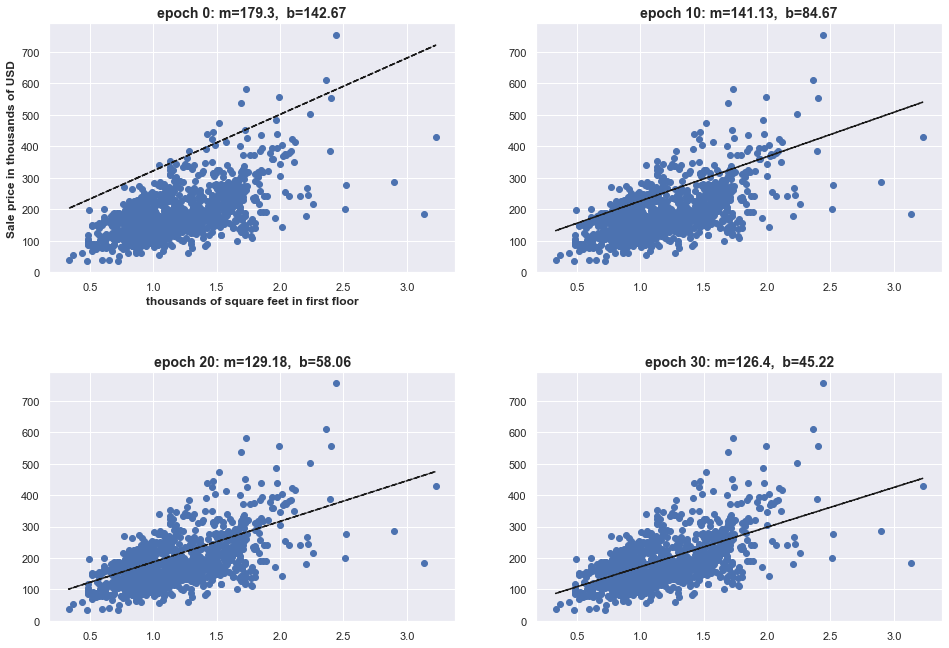

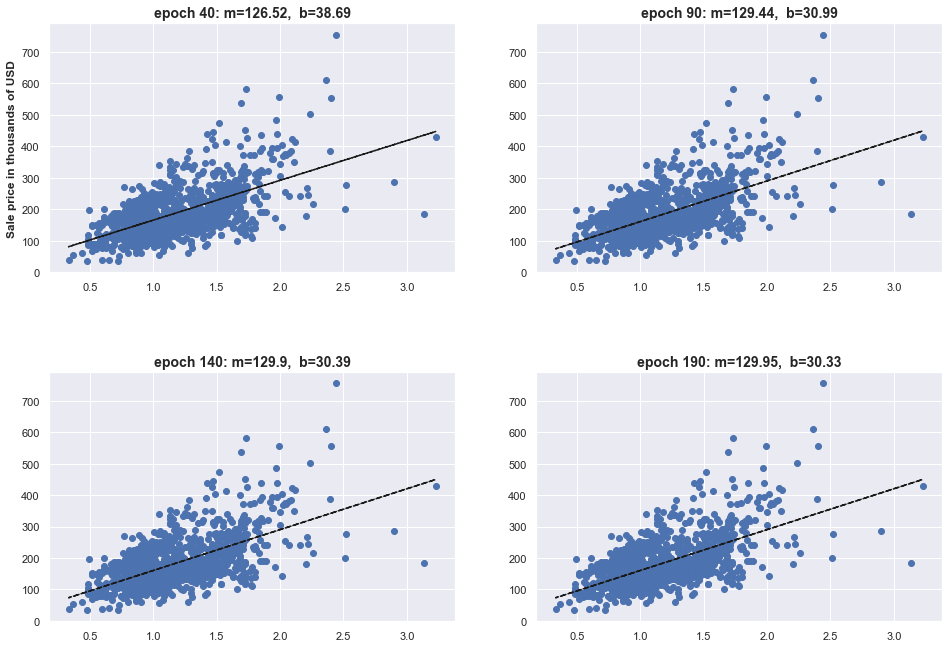

In [292]:
# el progreso es más notable en las primeras iteraciones
plot_model_progress(fst_fl_sqf_model[:40], fst_fl_sqf, sale_price, 10, 'thousands of square feet in first floor')
plot_model_progress(fst_fl_sqf_model[40:], fst_fl_sqf, sale_price, 50, '', epoch_offset=40)

## Entrenamiento manual del modelo